# Pycaret

[PCoE][pcoe]の No.6 Turbofan Engine Degradation Simulation Dataset に対して [Pycaret][pycaret] を利用したAutoMLの実行テスト。

[pcoe]: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/
[pycaret]: https://pycaret.readthedocs.io/en/latest/index.html


# Install Pycaret

In [1]:
try:
    import pycaret as pc
except ModuleNotFoundError:
    # https://github.com/pycaret/pycaret/blob/master/tutorials/Regression%20Tutorial%20Level%20Beginner%20-%20REG101.ipynb
    !pip install pycaret


import pycaret as pc
import pycaret.regression as pcregression
import pycaret.utils as pcutils


pcutils.enable_colab()

     |████████████████████████████████| 266kB 7.5MB/s 
     |████████████████████████████████| 112kB 14.5MB/s 
     |████████████████████████████████| 245kB 14.3MB/s 
     |████████████████████████████████| 14.2MB 240kB/s 
     |████████████████████████████████| 174kB 57.4MB/s 
     |████████████████████████████████| 2.0MB 33.9MB/s 
     |████████████████████████████████| 1.7MB 37.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 6.8MB 21.3MB/s 
     |████████████████████████████████| 1.4MB 42.3MB/s 
     |████████████████████████████████| 276kB 49.2MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 1.1MB 38.4MB/s 
     |████████████████████████████████| 3.2MB 39.3MB/

# Preset

In [2]:
# default packages
import logging
import pathlib
import zipfile
from typing import Any, Dict, List, Sequence, Tuple

In [3]:
# third party packages
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import sklearn.model_selection as skmselection
import tqdm.autonotebook as tqdm

In [4]:
# mode
MODE_DEBUG = False

In [5]:
# logger
_logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG if MODE_DEBUG else logging.INFO)

In [6]:
# seaborn
sns.set()

# Global parameters

In [7]:
PATH_ARCHIVE = pathlib.Path("turbofun.zip")
PATH_EXTRACT = pathlib.Path("turbofun")

In [8]:
# 利用する変数を定義
COLUMNS_ALL = [
    *[f"op{i:02}" for i in range(3)],
    *[f"sensor{i:02}" for i in range(26)],
]
COLUMNS_INVALID = [
    "op02",
    "sensor01",
    "sensor04",
    "sensor09",
    "sensor15",
    "sensor17",
    "sensor18",
    "sensor21",
    "sensor22",
    "sensor23",
    "sensor24",
    "sensor25",
]
COLUMNS_VALID = sorted(list(set(COLUMNS_ALL) - set(COLUMNS_INVALID)))

COLUMNS_TARGET = ["rul"]

# Load dataset

In [9]:
def download(filename: pathlib.Path) -> None:
    """zipファイルをダウンロード."""
    if filename.exists():
        return

    url = "https://ti.arc.nasa.gov/c/6/"
    res = requests.get(url, stream=True)
    if res.status_code != 200:
        _logger.error(res.status_code)
        return

    with open(filename, "wb") as f:
        for chunk in tqdm.tqdm(res):
            f.write(chunk)


download(PATH_ARCHIVE)

0it [00:00, ?it/s]

In [10]:
def extractall(src: pathlib.Path, dst: pathlib.Path) -> None:
    """zipファイルを解凍."""
    if not src.exists():
        _logger.error(f"{src} does not exist.")
        return
    if dst.exists():
        _logger.error(f"{dst} exists.")
        return

    with zipfile.ZipFile(src) as zf:
        zf.extractall(dst)


extractall(PATH_ARCHIVE, PATH_EXTRACT)

# Convert data shape

In [11]:
def get_unit_series(df: pd.DataFrame, unit: int) -> Dict[str, Any]:
    """unit単位のnumpy.arrayへ変換する."""
    df_unit = df[df["unit"] == unit].copy()
    df_unit.sort_values(by=["time"], ignore_index=True, inplace=True)
    names_op = [f"op{i:02}" for i in range(3)]
    names_sensor = [f"sensor{i:02}" for i in range(26)]
    data = {
        "unit": unit,
        **{name: df_unit[name].to_numpy().ravel() for name in names_op},
        **{name: df_unit[name].to_numpy().ravel() for name in names_sensor},
    }

    return data


def load_data(filename: pathlib.Path) -> pd.DataFrame:
    """データを読み取り、1セルに1unit分のデータをnumpy.arrayで保持するDataFrameとする."""
    df = pd.read_csv(
        filename,
        header=None,
        sep=" ",
        names=[
            "unit",
            "time",
            *[f"op{i:02d}" for i in range(3)],
            *[f"sensor{i:02d}" for i in range(26)],
        ],
    )

    return df


DF_FD001_TRAIN = load_data(PATH_EXTRACT.joinpath("train_FD001.txt"))
DF_FD001_TEST = load_data(PATH_EXTRACT.joinpath("test_FD001.txt"))

In [12]:
display.display(DF_FD001_TRAIN)

,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,NaN,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,NaN,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,NaN,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,NaN,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,NaN,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,NaN,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,NaN,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,NaN,NaN,NaN


In [13]:
display.display(DF_FD001_TEST)

,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,NaN,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,NaN,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,NaN,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,NaN,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN,NaN,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN,NaN,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN,NaN,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN,NaN,NaN,NaN


In [14]:
def load_rul(filepath: pathlib.Path) -> pd.DataFrame:
    """テスト用のRULを読み込む."""
    df = pd.read_csv(
        filepath,
        header=None,
        sep=" ",
        names=["rul", "none"],
    )
    df.drop(["none"], axis=1, inplace=True)
    df["unit"] = range(len(df))
    df.set_index(["unit"], inplace=True)

    return df


DF_FD001_TEST_RUL = load_rul(PATH_EXTRACT.joinpath("RUL_FD001.txt"))
display.display(DF_FD001_TEST_RUL)

,rul
unit,
0,112
1,98
2,69
3,82
4,91
5,93
6,91
7,95
8,111


In [15]:
def create_train_rul(df: pd.DataFrame) -> pd.Series:
    """学習データに対するRULを算出する."""
    df_rul = df.copy()
    df_max_time = df.groupby(["unit"])["time"].max()
    df_rul["rul"] = df_rul.apply(
        lambda x: df_max_time.at[x["unit"]] - x["time"],
        axis=1,
    )

    return df_rul



DF_FD001_TRAIN = create_train_rul(DF_FD001_TRAIN)
display.display(DF_FD001_TRAIN)

,unit,time,op00,op01,op02,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,NaN,NaN,NaN,191.0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,NaN,NaN,NaN,190.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,NaN,NaN,NaN,189.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,NaN,NaN,NaN,188.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,NaN,NaN,NaN,187.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,NaN,NaN,NaN,4.0
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,NaN,NaN,NaN,3.0
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,NaN,NaN,NaN,2.0
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,NaN,NaN,NaN,1.0


# Data split

In [16]:
def train_test_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """学習用データと検証用データを分割する."""
    units = df["unit"].unique()
    units_train, units_test = skmselection.train_test_split(
        units,
        test_size=0.2,
        random_state=42,
    )

    df_train = df[df["unit"].isin(units_train)]
    df_test = df[df["unit"].isin(units_test)]

    return df_train, df_test


DF_TRAIN, DF_VALID = train_test_split(DF_FD001_TRAIN)

In [17]:
DF_TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16561 entries, 192 to 20630
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   unit      16561 non-null  int64  
 1   time      16561 non-null  int64  
 2   op00      16561 non-null  float64
 3   op01      16561 non-null  float64
 4   op02      16561 non-null  float64
 5   sensor00  16561 non-null  float64
 6   sensor01  16561 non-null  float64
 7   sensor02  16561 non-null  float64
 8   sensor03  16561 non-null  float64
 9   sensor04  16561 non-null  float64
 10  sensor05  16561 non-null  float64
 11  sensor06  16561 non-null  float64
 12  sensor07  16561 non-null  float64
 13  sensor08  16561 non-null  float64
 14  sensor09  16561 non-null  float64
 15  sensor10  16561 non-null  float64
 16  sensor11  16561 non-null  float64
 17  sensor12  16561 non-null  float64
 18  sensor13  16561 non-null  float64
 19  sensor14  16561 non-null  float64
 20  sensor15  16561 non-null  

In [18]:
DF_VALID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4070 entries, 0 to 18514
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   unit      4070 non-null   int64  
 1   time      4070 non-null   int64  
 2   op00      4070 non-null   float64
 3   op01      4070 non-null   float64
 4   op02      4070 non-null   float64
 5   sensor00  4070 non-null   float64
 6   sensor01  4070 non-null   float64
 7   sensor02  4070 non-null   float64
 8   sensor03  4070 non-null   float64
 9   sensor04  4070 non-null   float64
 10  sensor05  4070 non-null   float64
 11  sensor06  4070 non-null   float64
 12  sensor07  4070 non-null   float64
 13  sensor08  4070 non-null   float64
 14  sensor09  4070 non-null   float64
 15  sensor10  4070 non-null   float64
 16  sensor11  4070 non-null   float64
 17  sensor12  4070 non-null   float64
 18  sensor13  4070 non-null   float64
 19  sensor14  4070 non-null   float64
 20  sensor15  4070 non-null   flo

# Pycaret

In [19]:
def fit(df: pd.DataFrame, column_target: str) -> Any:
    """モデルの探索."""
    budget_time = 10 if MODE_DEBUG else 60  # minutes

    # session_id = random_seed
    experiment = pcregression.setup(
        data=df,
        target=column_target,
        session_id=42,
        fold_strategy="timeseries",
        fold=5,
        n_jobs=-1,
        use_gpu=False,
    )
    model_best = pcregression.compare_models(
        n_select=1,
        budget_time=budget_time,
    )

    return model_best


MODEL_BEST = fit(DF_TRAIN[COLUMNS_VALID + COLUMNS_TARGET], COLUMNS_TARGET[0])
_logger.info(MODEL_BEST)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,30.5602,1862.9880,43.1533,0.6188,0.4041,0.3789,2.422
gbr,Gradient Boosting Regressor,30.9939,1883.0426,43.3873,0.6147,0.4317,0.4027,1.528
rf,Random Forest Regressor,30.7905,1894.4227,43.5175,0.6124,0.4082,0.3825,4.798
lightgbm,Light Gradient Boosting Machine,31.2357,1950.4700,44.1520,0.6010,0.4194,0.3862,0.294
ridge,Ridge Regression,35.0138,2127.9592,46.1240,0.5646,0.5920,0.7552,0.038
lr,Linear Regression,35.0280,2129.0269,46.1354,0.5644,0.5935,0.7579,0.538
lar,Least Angle Regression,35.0311,2129.3824,46.1393,0.5643,0.5938,0.7584,0.044
br,Bayesian Ridge,35.0517,2132.8742,46.1772,0.5636,0.5908,0.7540,0.046
lasso,Lasso Regression,36.0280,2230.7226,47.2258,0.5435,0.6091,0.8013,0.040
en,Elastic Net,36.7796,2309.7099,48.0537,0.5273,0.6279,0.8237,0.042


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 2
INFO:logs:ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:__main__:ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_sam

In [20]:
MODEL_FINAL = pcregression.finalize_model(MODEL_BEST)
_logger.info(MODEL_FINAL)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False), fit_kwargs=None, groups=None, model_only=True, display=None)
INFO:logs:Finalizing ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
              

In [21]:
def tune_lgbm(df: pd.DataFrame, column_target: str) -> Any:
    budget_time = 10 if MODE_DEBUG else 60  # minutes
    lgbm_params = {
        'num_leaves': np.arange(10,200,10),
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
        'learning_rate': np.arange(0.1,1,0.1),
    }

    # session_id = random_seed
    experiment = pcregression.setup(
        data=df,
        target=column_target,
        session_id=42,
        fold_strategy="timeseries",
        fold=5,
        n_jobs=-1,
        use_gpu=False,
    )

    lightgbm = pcregression.create_model("lightgbm")
    tuned_lightgbm = pcregression.tune_model(lightgbm, custom_grid=lgbm_params)

    return tuned_lightgbm


TUNED_LIGHTGBM = tune_lgbm(DF_TRAIN[COLUMNS_VALID + COLUMNS_TARGET], COLUMNS_TARGET[0])
_logger.info(TUNED_LIGHTGBM)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,32.0496,2034.8393,45.1092,0.5957,0.4327,0.3985
1,31.2144,1980.9343,44.5077,0.5831,0.3890,0.3483
2,32.4870,2084.4260,45.6555,0.5769,0.4198,0.3869
3,31.0823,1930.9332,43.9424,0.6093,0.4162,0.3907
4,30.7909,1902.2723,43.6150,0.6024,0.4063,0.3720
Mean,31.5248,1986.6810,44.5660,0.5935,0.4128,0.3793
SD,0.6375,66.5417,0.7455,0.0120,0.0146,0.0177


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=70,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=80, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................
INFO:__main__:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=70,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=80, objective=None,
              random_state=42, reg_a

In [22]:
FINAL_LIGHTGBM = pcregression.finalize_model(TUNED_LIGHTGBM)
_logger.info(FINAL_LIGHTGBM)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=70,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=80, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), fit_kwargs=None, groups=None, model_only=True, display=None)
INFO:logs:Finalizing LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=70,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=80, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
             

## Results

In [23]:
def predict(
    model: Any,
    df_info: pd.DataFrame,
    df_feature: pd.DataFrame,
    df_target: pd.DataFrame,
    units: List[int],
) -> None:
    """予測結果を可視化する."""
    results = pcregression.predict_model(model, data=df_feature)
    df_results = df_info.copy()
    df_results["rul"] = df_target.to_numpy().ravel()
    df_results["pred"] = results["Label"]

    for unit in units:
        df_target = df_results[df_results["unit"] == unit]
        fig, axes = plt.subplots(1, 1, figsize=(9, 4), tight_layout=True)
        ax = axes
        ax.plot(df_target["time"], df_target["rul"], label="rul")
        ax.plot(df_target["time"], df_target["pred"], label="pred")
        ax.set_title(f"unit{unit:02}")
        plt.show()
        plt.close()
        fig.clf()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


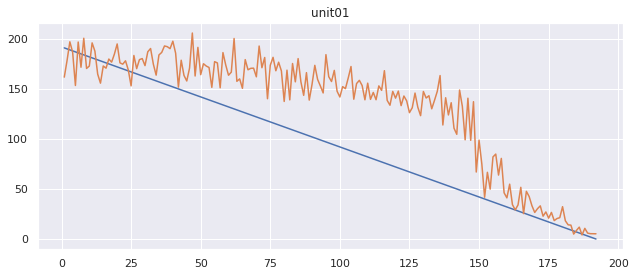

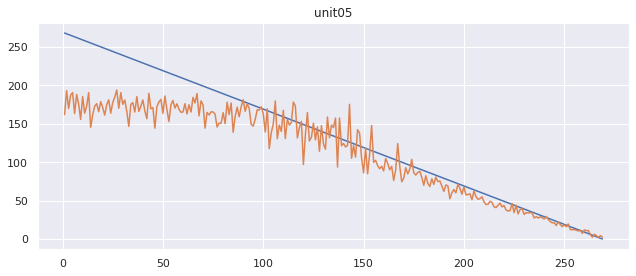

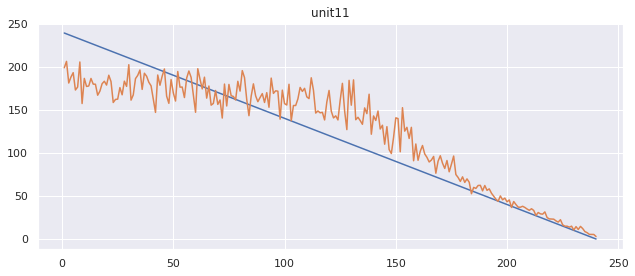

In [24]:
predict(
    MODEL_FINAL,
    DF_VALID[["unit", "time"]],
    DF_VALID[COLUMNS_VALID],
    DF_VALID[COLUMNS_TARGET],
    DF_VALID["unit"].unique()[:3],
)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=70,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=80, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


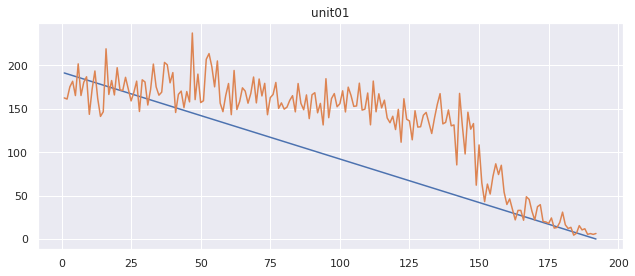

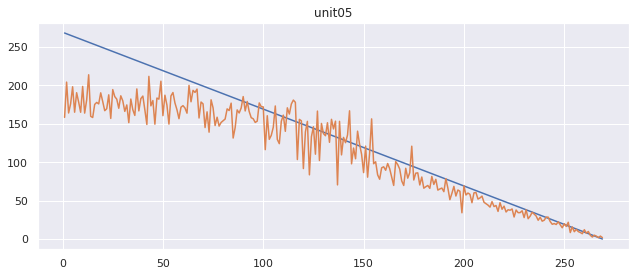

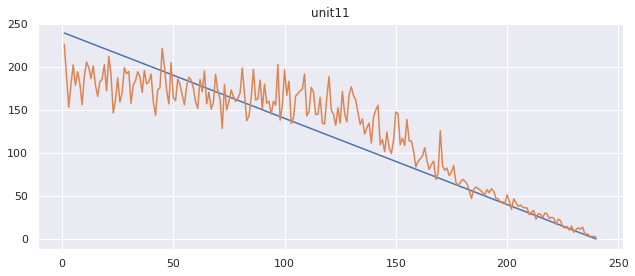

In [25]:
predict(
    FINAL_LIGHTGBM,
    DF_VALID[["unit", "time"]],
    DF_VALID[COLUMNS_VALID],
    DF_VALID[COLUMNS_TARGET],
    DF_VALID["unit"].unique()[:3],
)

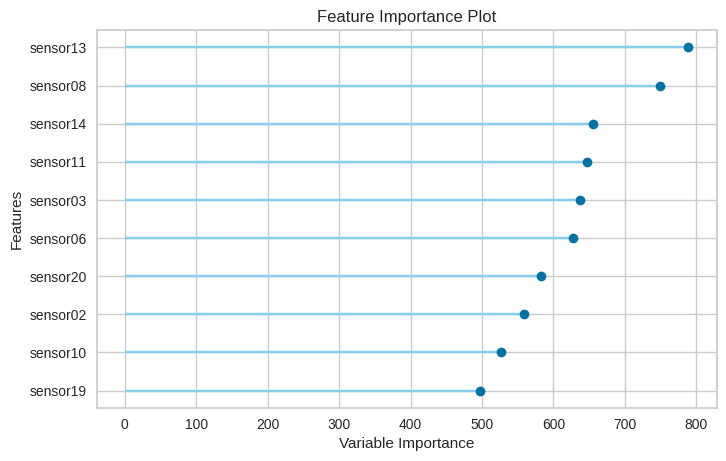

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [26]:
pcregression.plot_model(FINAL_LIGHTGBM, plot="feature")